In [22]:
import os,sys
sys.path.insert(0,"..")
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from dataset import MIMIC_Dataset

device = 'cuda'
torch.cuda.is_available()

True

In [23]:
import torchxrayvision as xrv
transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(),xrv.datasets.XRayResizer(224)])

In [24]:
d_mimic_chex = MIMIC_Dataset(#datadir="/lustre03/project/6008064/jpcohen/MIMICCXR-2.0/files",
          imgpath="/local/eb/aa5506/MIMIC-CXR-JPG/mimic-cxr-jpg/2.1.0/files",
          csvpath="/local/eb/aa5506/MIMIC-CXR-JPG/mimic-cxr-jpg/2.1.0/mimic-cxr-2.0.0-chexpert.csv",
          metacsvpath="/local/eb/aa5506/MIMIC-CXR-JPG/mimic-cxr-jpg/2.1.0/mimic-cxr-2.0.0-metadata.csv",
          views=["PA","AP"], unique_patients=True,
          transform=transform)
d_mimic_chex 

{np.str_('Atelectasis'): {np.float32(0.0): 43178, np.float32(1.0): 7289},
 np.str_('Cardiomegaly'): {np.float32(0.0): 45199, np.float32(1.0): 7261},
 np.str_('Consolidation'): {np.float32(0.0): 45256, np.float32(1.0): 2068},
 np.str_('Edema'): {np.float32(0.0): 47067, np.float32(1.0): 3366},
 np.str_('Effusion'): {np.float32(0.0): 47204, np.float32(1.0): 5688},
 np.str_('Enlarged Cardiomediastinum'): {np.float32(0.0): 44047,
                                         np.float32(1.0): 1583},
 np.str_('Fracture'): {np.float32(0.0): 43177, np.float32(1.0): 1552},
 np.str_('Lung Lesion'): {np.float32(0.0): 43192, np.float32(1.0): 1740},
 np.str_('Lung Opacity'): {np.float32(0.0): 43482, np.float32(1.0): 9347},
 np.str_('Pleural Other'): {np.float32(0.0): 43003, np.float32(1.0): 569},
 np.str_('Pneumonia'): {np.float32(0.0): 46492, np.float32(1.0): 3316},
 np.str_('Pneumothorax'): {np.float32(0.0): 49140, np.float32(1.0): 823},
 np.str_('Support Devices'): {np.float32(0.0): 43352, np.float32(

MIMIC_Dataset num_samples=63945 views=['PA', 'AP'] data_aug=None

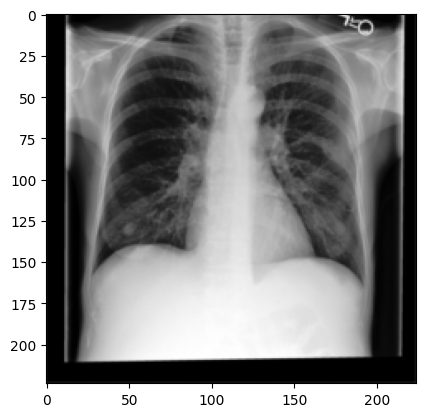

In [25]:
import matplotlib.pyplot as plt
img = d_mimic_chex[0]['img']
plt.imshow(img[0], cmap='gray')

In [28]:
model = xrv.models.DenseNet(weights="densenet121-res224-mimic_nb")

If this fails you can run `wget https://github.com/mlmed/torchxrayvision/releases/download/v1/mimic_nb-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt -O /home/aa5506/.torchxrayvision/models_data/mimic_nb-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt`
[██████████████████████████████████████████████████]


In [ ]:
model = model.to(device)
model.eval()

XRV-DenseNet121-densenet121-res224-mimic_nb


In [37]:
inp = torch.tensor(img).unsqueeze(0).to(device)
print(model.features2(inp).shape)

torch.Size([1, 1024])


In [42]:
dataloader = torch.utils.data.DataLoader(d_mimic_chex, batch_size=64, shuffle=False, num_workers=8)
import pickle as pkl
from tqdm import tqdm

def get_features(model, dataloader):
    features = []
    with torch.no_grad():
        for i, data in enumerate(tqdm(dataloader)):
            inputs = data['img'].to(device)
            outputs = model.features2(inputs)
            
            # split the batch up
            for j in range(outputs.shape[0]):
                features.append({
                    'emb': outputs[j].cpu().numpy(),
                    'subject': data['subject_id'][j],
                    'study': data['study_id'][j],
                    'dicom': data['dicom_id'][j],
                })
            break
    with open('torchxray-resnet-features.pkl', 'wb') as f:
        pickle.dump(features, f)

In [43]:
get_features(model, dataloader)

  0%|          | 0/1000 [00:17<?, ?it/s]


NameError: name 'pickle' is not defined